In [1]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader


In [67]:
#device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"

In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import torch
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_path = '/home/montasir/Desktop/New Experiment/imagenette2/train'

full_dataset = ImageFolder(
        root=data_path,
        transform=data_transforms
    )




In [4]:
#for selecting 50 images from a particular class
import random
from torch.utils.data import Subset

selected_class = 'n03888257'  #parachute class
selected_indices = []
for i in range(len(full_dataset)):
    if full_dataset.targets[i] == full_dataset.class_to_idx[selected_class]:
        selected_indices.append(i)

if len(selected_indices) >= 20:  #selecting 100 images from the kites class
    selected_indices = random.sample(selected_indices, 20)
else:
    print(f"Warning: There are fewer than 100 images available for class '{selected_class}'.")

selected_images = Subset(full_dataset, selected_indices)

Selecting Single image from all classes

In [22]:
#for selecting single images from all the classes
class_indices = {}
for idx, (image, label) in enumerate(full_dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(idx)


In [23]:
#for selecting single images from all the classes
selected_indices = []
for label in class_indices:
    selected_indices.append(class_indices[label][10])
selected_images = Subset(full_dataset, selected_indices)


In [3]:
# Random selection 
import random
from torch.utils.data import Subset
num_images_to_select = 50
selected_indices = random.sample(range(len(full_dataset)), num_images_to_select)
selected_images= Subset(full_dataset, selected_indices)


In [105]:
#converting tensor to image
#Checking of image
from torchvision.transforms import ToPILImage
tensor_image = selected_images[9][0]
to_pil = ToPILImage()
pil_image = to_pil(tensor_image)
pil_image.show()


In [5]:
import transformers
from transformers import CLIPModel,CLIPTokenizer,CLIPProcessor

checkpoint= "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
tokenizer=CLIPTokenizer.from_pretrained(checkpoint)
processor=CLIPProcessor.from_pretrained(checkpoint)
model=CLIPModel.from_pretrained(checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
model.to(device)

In [28]:
model.save_pretrained('saved_vitH14')
tokenizer.save_pretrained('saved_vitH14')
processor.save_pretrained('saved_vitH14')

In [24]:
from torch.utils.data import DataLoader
batch_size = 5
dataloader = DataLoader(selected_images, batch_size=batch_size)



In [8]:

for batch_images, batch_labels in dataloader:
    print("Batch Images:")
    print(batch_images[0].shape)
    print("Batch Labels:")
    print(batch_labels[0])


  

Batch Images:
torch.Size([3, 224, 224])
Batch Labels:
tensor(9)
Batch Images:
torch.Size([3, 224, 224])
Batch Labels:
tensor(9)
Batch Images:
torch.Size([3, 224, 224])
Batch Labels:
tensor(9)
Batch Images:
torch.Size([3, 224, 224])
Batch Labels:
tensor(9)


In [25]:
all_img_embds = []  #final embedding list having all batches of images
for batch_images, batch_labels in dataloader:
    batch_embds = []  #for current batches
    for i in range(len(batch_images)):
        image = batch_images[i]  
        print(image.shape)

        # Process the individual image
        #inputs = processor(images=image.unsqueeze(0), return_tensors="pt")  # Convert to a batch of size 1
        input_pixels = image.unsqueeze(0)
        img_embd = model.get_image_features(pixel_values=input_pixels)
        batch_embds.append(img_embd)
        
    all_img_embds.append(batch_embds)




torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [26]:
all_img_embds_combined = []

for x in all_img_embds:
    for embd in x:
        all_img_embds_combined.append(embd)


In [74]:
 
 '''Wrong Implementation'''
 '''
 
 all_img_embds=[]
 for batch_images,batch_labels in dataloader:
    #inputs=processor(images=batch_images,return_tensors="pt")
    input_pixels=inputs['pixel_values']
    img_embd= model.get_image_features(pixel_values=input_pixels)
    #print(img_embd)
    all_img_embds.append(img_embd)




            
  '''' 


In [7]:
file_path = "/home/montasir/Desktop/New Experiment/image_embeddings_100_random_images.pt"

# Concatenate all the embeddings along a new dimension
all_img_embds_tensor = torch.stack(all_img_embds, dim=0)


# Save the tensor to the specified file
torch.save(all_img_embds_tensor, file_path)

print("Image embeddings saved to", file_path)

Image embeddings saved to /home/montasir/Desktop/New Experiment/image_embeddings_100_random_images.pt


In [27]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

flattened_embds = []

for embd in all_img_embds_combined:
    flattened_embd = embd.squeeze().detach().numpy()
    flattened_embds.append(flattened_embd)

img_embds_array = np.array(flattened_embds)

similarities = cosine_similarity(img_embds_array)
print(similarities)



[[1.0000004  0.50513285 0.32181546 0.33683667 0.26859143 0.3637434
  0.34985128 0.37156555 0.32449746 0.3705426 ]
 [0.50513285 1.0000001  0.37144867 0.36479655 0.33583155 0.44327623
  0.41281858 0.4399389  0.36780924 0.42528665]
 [0.32181546 0.37144867 1.         0.44384307 0.34886917 0.51368225
  0.37252724 0.4715109  0.3346917  0.39113897]
 [0.33683667 0.36479655 0.44384307 0.99999994 0.28461388 0.4468385
  0.35966823 0.52289224 0.29423252 0.39951724]
 [0.26859143 0.33583155 0.34886917 0.28461388 1.0000002  0.34619468
  0.36251083 0.45657083 0.24948242 0.32962203]
 [0.3637434  0.44327623 0.51368225 0.4468385  0.34619468 1.0000002
  0.41176274 0.4943041  0.3426552  0.4593567 ]
 [0.34985128 0.41281858 0.37252724 0.35966823 0.36251083 0.41176274
  1.0000002  0.53429866 0.37932208 0.37208283]
 [0.37156555 0.4399389  0.4715109  0.52289224 0.45657083 0.4943041
  0.53429866 1.0000002  0.41256654 0.44647092]
 [0.32449746 0.36780924 0.3346917  0.29423252 0.24948242 0.3426552
  0.37932208 0.41

In [20]:
similarities.flatten()

array([0.99999976, 0.65833277, 0.6661346 , 0.6631496 , 0.688945  ,
       0.63736045, 0.63213843, 0.5748933 , 0.5373297 , 0.62156105,
       0.67455465, 0.64933413, 0.62880564, 0.43906605, 0.6543019 ,
       0.62376505, 0.56665015, 0.5472773 , 0.6072678 , 0.6915779 ,
       0.65833277, 1.        , 0.7527425 , 0.7613249 , 0.7377789 ,
       0.7802908 , 0.7183816 , 0.55812794, 0.6028268 , 0.6713939 ,
       0.6068784 , 0.8882499 , 0.74330014, 0.56153077, 0.73189485,
       0.8641437 , 0.59689945, 0.63658893, 0.60982925, 0.7897819 ,
       0.6661346 , 0.7527425 , 1.0000004 , 0.73972964, 0.80773586,
       0.77197665, 0.69783944, 0.4935656 , 0.65692025, 0.70949286,
       0.6851091 , 0.82081294, 0.7719741 , 0.5464368 , 0.79012173,
       0.8201846 , 0.5545456 , 0.69677716, 0.6970586 , 0.7864441 ,
       0.6631496 , 0.7613249 , 0.73972964, 1.0000001 , 0.70492154,
       0.7600362 , 0.6890616 , 0.5496617 , 0.6325447 , 0.59191066,
       0.63325435, 0.7618391 , 0.73520684, 0.4839989 , 0.72817

In [28]:
import torch.nn.functional as F
class_names=full_dataset.classes
parachute_class_index= class_names.index('n03888257')
parachute_class_embeddings=img_embds_array[parachute_class_index]

similarities = cosine_similarity([parachute_class_embeddings], img_embds_array)

for i, similarity in enumerate(similarities[0]):
    if i != parachute_class_index:
        class_name_i = class_names[i]
        print(f"Similarity between parachute class and {class_name_i}: {similarity:.4f}")

Similarity between parachute class and n01440764: 0.3705
Similarity between parachute class and n02102040: 0.4253
Similarity between parachute class and n02979186: 0.3911
Similarity between parachute class and n03000684: 0.3995
Similarity between parachute class and n03028079: 0.3296
Similarity between parachute class and n03394916: 0.4594
Similarity between parachute class and n03417042: 0.3721
Similarity between parachute class and n03425413: 0.4465
Similarity between parachute class and n03445777: 0.4827


In [29]:
min(similarities[0])

0.3296222

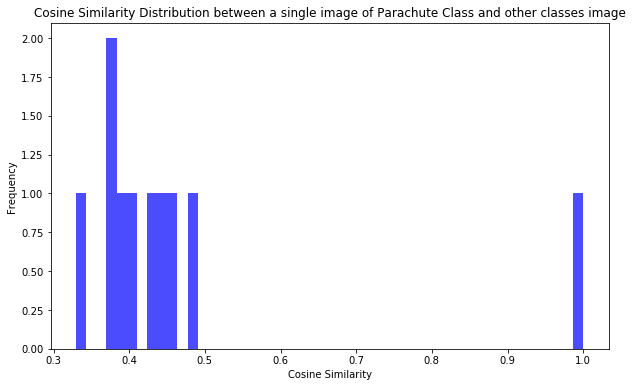

In [31]:
#for single images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(similarities[0],bins=50,alpha=0.7, color='blue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distribution between a single image of Parachute Class and other classes image')
#plt.legend()
plt.show()

In [14]:
class_names = full_dataset.classes
import torch
from sklearn.metrics.pairwise import cosine_similarity
image_embeddings_matrix = torch.cat(all_img_embds, dim=0)
image_embeddings_array = image_embeddings_matrix.detach().numpy()
similarities = cosine_similarity(image_embeddings_array)
for i in range(len(similarities)):
    for j in range(i+1, len(similarities)):
        similarity = similarities[i][j]
        class_name_i = class_names[i]
        class_name_j = class_names[j]
        print(f"Similarity between {class_name_i} and {class_name_j}: {similarity:.4f}")

Similarity between n01440764 and n02102040: 0.9689
Similarity between n01440764 and n02979186: 0.9016
Similarity between n01440764 and n03000684: 0.6106
Similarity between n01440764 and n03028079: 0.9551
Similarity between n01440764 and n03394916: 0.8195
Similarity between n01440764 and n03417042: 0.9011
Similarity between n01440764 and n03425413: 0.9047
Similarity between n01440764 and n03445777: 0.5922
Similarity between n01440764 and n03888257: 0.8704
Similarity between n02102040 and n02979186: 0.9163
Similarity between n02102040 and n03000684: 0.6409
Similarity between n02102040 and n03028079: 0.9466
Similarity between n02102040 and n03394916: 0.8388
Similarity between n02102040 and n03417042: 0.9227
Similarity between n02102040 and n03425413: 0.9231
Similarity between n02102040 and n03445777: 0.6105
Similarity between n02102040 and n03888257: 0.9033
Similarity between n02979186 and n03000684: 0.7571
Similarity between n02979186 and n03028079: 0.9272
Similarity between n02979186 an

In [219]:
min(similarities.flatten())

0.3296222

In [19]:
image_embeddings_matrix


tensor([[ 0.3094,  0.2458, -0.3469,  ..., -0.5894,  0.4331,  0.0313],
        [ 0.0749,  0.0133,  0.0185,  ..., -0.4689,  0.0945,  0.2876],
        [ 0.3079,  0.0987, -0.3476,  ..., -0.6532,  0.5455,  0.0268],
        ...,
        [ 0.4124,  0.1638, -0.2354,  ..., -0.3524,  0.1975,  0.2465],
        [ 0.2902,  0.2584, -0.4053,  ..., -0.2794,  0.2147,  0.1335],
        [ 0.4770,  0.1286, -0.0528,  ..., -0.6504,  0.5659, -0.0580]],
       grad_fn=<CatBackward0>)

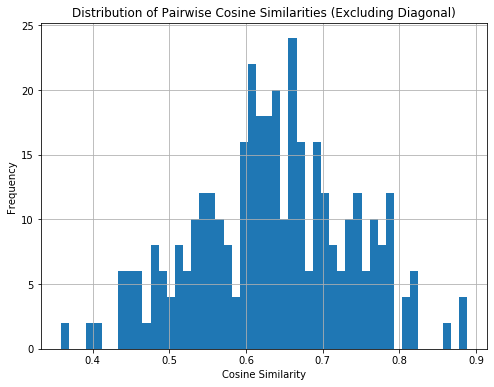

In [21]:
import numpy as np
import matplotlib.pyplot as plt
similarities=np.round(similarities,4)

flattened_similarities = similarities.flatten()
flattened_similarities = flattened_similarities[flattened_similarities != 1.0000] #removing diagonal elements

plt.figure(figsize=(8, 6))
plt.hist(flattened_similarities,bins=50)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Cosine Similarities (Excluding Diagonal)')
plt.grid(True)
plt.show()


In [34]:
max(flattened_similarities)

0.8882

In [17]:
image_embeddings_matrix = torch.cat(all_img_embds, dim=0)
image_embeddings_matrix

tensor([[ 0.3491,  0.0556, -0.2880,  ..., -0.6221,  0.6633, -0.0356],
        [ 0.2156,  0.2027, -0.2616,  ..., -0.6804,  0.6071, -0.0644],
        [ 0.4401, -0.0587, -0.0802,  ..., -0.6848,  0.4497,  0.1071],
        ...,
        [ 0.3205, -0.0069, -0.1971,  ..., -0.4775,  0.3446,  0.1413],
        [ 0.1355, -0.1004,  0.5898,  ..., -0.2151, -0.4568, -0.0150],
        [ 0.3973,  0.2848, -0.0666,  ..., -0.5902,  0.0263, -0.0850]],
       grad_fn=<CatBackward0>)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity


def calculating_cosine_similarities(embeddings):
   
    image_embeddings_array = embeddings.detach().numpy()
    similarities = cosine_similarity(image_embeddings_array)
    return similarities
    

In [20]:
cos_sim=calculating_cosine_similarities(image_embeddings_matrix)
print(cos_sim)

[[1.0000002  0.96892124 0.9016295  0.61063135 0.9550816  0.8194906
  0.9010563  0.90473366 0.5921674  0.87041175]
 [0.96892124 1.0000002  0.91625524 0.6409216  0.9466369  0.83882153
  0.9226897  0.9230794  0.61053836 0.90329564]
 [0.9016295  0.91625524 1.0000001  0.75709367 0.9272368  0.870682
  0.9520684  0.91331166 0.70614475 0.896831  ]
 [0.61063135 0.6409216  0.75709367 0.9999999  0.68846524 0.7372068
  0.7193649  0.71064395 0.63595814 0.6905483 ]
 [0.9550816  0.9466369  0.9272368  0.68846524 1.0000005  0.8927006
  0.9265893  0.9509785  0.6648353  0.90587765]
 [0.8194906  0.83882153 0.870682   0.7372068  0.8927006  1.0000004
  0.87154543 0.9231646  0.7139759  0.8900227 ]
 [0.9010563  0.9226897  0.9520684  0.7193649  0.9265893  0.87154543
  0.9999999  0.9197585  0.68362826 0.9121522 ]
 [0.90473366 0.9230794  0.91331166 0.71064395 0.9509785  0.9231646
  0.9197585  1.0000004  0.7001305  0.9110748 ]
 [0.5921674  0.61053836 0.70614475 0.63595814 0.6648353  0.7139759
  0.68362826 0.70013

In [21]:
mean_vector=torch.mean(image_embeddings_matrix,dim=0)
#mean_vector=mean_vector.reshape(-1,1)
normalized_embeddings=image_embeddings_matrix-mean_vector
normalized_embeddings

tensor([[-1.5089e-02,  3.8833e-04, -2.4228e-01,  ..., -9.2558e-02,
          4.3736e-01, -5.7861e-02],
        [-1.4862e-01,  1.4740e-01, -2.1588e-01,  ..., -1.5089e-01,
          3.8117e-01, -8.6673e-02],
        [ 7.5850e-02, -1.1391e-01, -3.4509e-02,  ..., -1.5525e-01,
          2.2384e-01,  8.4794e-02],
        ...,
        [-4.3730e-02, -6.2141e-02, -1.5140e-01,  ...,  5.2036e-02,
          1.1867e-01,  1.1906e-01],
        [-2.2868e-01, -1.5565e-01,  6.3551e-01,  ...,  3.1443e-01,
         -6.8273e-01, -3.7326e-02],
        [ 3.3119e-02,  2.2957e-01, -2.0930e-02,  ..., -6.0658e-02,
         -1.9959e-01, -1.0725e-01]], grad_fn=<SubBackward0>)

In [22]:
#normalized_cosine_similarity
cos_sim_norm=calculating_cosine_similarities(normalized_embeddings)
print(cos_sim_norm)

[[ 1.0000001   0.7557896   0.0612086  -0.48239583  0.58255965 -0.37244704
   0.10194016  0.06283943 -0.49779043 -0.05263706]
 [ 0.7557896   1.0000001   0.0654026  -0.4724777   0.393757   -0.3769656
   0.17905466  0.11372161 -0.5396482   0.10484967]
 [ 0.0612086   0.0654026   1.0000001  -0.03664554 -0.02088441 -0.28664523
   0.3434082  -0.21853465 -0.21574172 -0.15134275]
 [-0.48239583 -0.4724777  -0.03664554  1.         -0.46313912 -0.03975463
  -0.17987534 -0.34828132  0.10144262 -0.25506663]
 [ 0.58255965  0.393757   -0.02088441 -0.46313912  1.         -0.06752921
  -0.01912054  0.3023859  -0.47366646 -0.06637043]
 [-0.37244704 -0.3769656  -0.28664523 -0.03975463 -0.06752921  1.
  -0.27395716  0.25335294 -0.04207187  0.06096942]
 [ 0.10194016  0.17905466  0.3434082  -0.17987534 -0.01912054 -0.27395716
   0.99999976 -0.125023   -0.29451865  0.05489436]
 [ 0.06283943  0.11372161 -0.21853465 -0.34828132  0.3023859   0.25335294
  -0.125023    0.9999997  -0.2753882  -0.01371202]
 [-0.4977

In [27]:
min(cos_sim_norm.flatten())

-0.5396482

In [24]:
def show_distributions(score):
    similarities=np.round(score,4)

    flattened_similarities = similarities.flatten()
    flattened_similarities = flattened_similarities[flattened_similarities != 1.0000] #removing diagonal elements

    plt.figure(figsize=(8, 6))
    plt.hist(flattened_similarities,bins=50)
    plt.xlabel('Normalized Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Normalized Pairwise Cosine Similarities')
    plt.grid(True)
    plt.show()





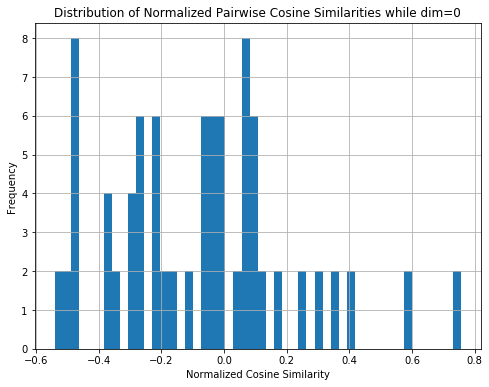

In [25]:
#normalized_distributions
show_distributions(cos_sim_norm)

In [62]:
a = torch.randn(4, 3)
print(a)
b=torch.mean(a, 1)
print(b)
b_reshaped = b.view(-1, 1)
diff=a-b_reshaped
print(diff)
print(b_reshaped.shape)


tensor([[ 0.5108, -1.7877, -0.8459],
        [-0.8026, -0.0094, -0.3568],
        [ 0.1120, -1.0091,  0.6086],
        [-1.8212,  0.1400,  1.4077]])
tensor([-0.7076, -0.3896, -0.0962, -0.0912])
tensor([[ 1.2184, -1.0801, -0.1383],
        [-0.4130,  0.3802,  0.0328],
        [ 0.2082, -0.9130,  0.7048],
        [-1.7301,  0.2312,  1.4989]])
torch.Size([4, 1])
